# Part 6: k-fold Cross Validation with RF

In [8]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [66]:
# Run some setup code for this notebook.
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import ipywidgets as widgets

from ipywidgets import VBox, HBox, Layout


from sklearn import preprocessing
from sklearn.utils import shuffle

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy import interp

from utils.checkbox import *
from utils.data_utils import *
#from utils.data_processing import *
from utils.svm_modeling import *
from utils.model_eval import *
from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
# Load data.
path = 'dataset_new'
feature_dict = load_features(path, dont_show=True)
#show_feature_details(feature_dict)

Feature dict loaded.



In [68]:
# Select some features.
use_all = False
#use_all = True

group_1 = [7, 23, 41]
group_2 = [7, 23, 41, 29, 55, 22]
group_3 = [7, 23, 41, 29, 55, 22, 25, 15, 35]

include_feature_groups = []
include_feature_index = group_3
exclude_feature_index = []

if use_all:
    include_feature_index = np.arange(1, len(feature_dict), 1)

feature_pre_selected = pre_select_feature(include_feature_groups, include_feature_index, exclude_feature_index, dont_show=True)
precheck_boxes = generate_precheck_boxes(feature_pre_selected, feature_dict, dont_show=True)

hbox = gen_checkbox(precheck_boxes, feature_dict)
HBox(hbox)

HBox(children=(VBox(children=(Checkbox(value=False, description='1_24h_urinary_microalbumin'), Checkbox(value=False, description='2_24h_urine_protein'), Checkbox(value=False, description='3_25oh_vd'), Checkbox(value=False, description='4_25oh_vd3'), Checkbox(value=False, description='5_2h_fasting_glucose'), Checkbox(value=False, description='6_8_blood_cortisol'), Checkbox(value=True, description='7_age'), Checkbox(value=False, description='8_alt'), Checkbox(value=False, description='9_ast'), Checkbox(value=False, description='10_blood_protein'), Checkbox(value=False, description='11_blood_urea_nitrogen'), Checkbox(value=False, description='12_blood_uric_acid'), Checkbox(value=False, description='13_c_peptide'), Checkbox(value=False, description='14_c_reactive_protein'), Checkbox(value=True, description='15_calf'))), VBox(children=(Checkbox(value=False, description='16_creatine_kinase'), Checkbox(value=False, description='17_creatinine'), Checkbox(value=False, description='18_cystatin_c'), Checkbox(value=False, description='19_fasting_glucose'), Checkbox(value=False, description='20_fasting_insulin'), Checkbox(value=False, description='21_ft3'), Checkbox(value=True, description='22_ft4'), Checkbox(value=True, description='23_gender'), Checkbox(value=False, description='24_glycated_hemoglobin'), Checkbox(value=True, description='25_grip_strength'), Checkbox(value=False, description='26_hbg'), Checkbox(value=False, description='27_hdlc'), Checkbox(value=False, description='28_height'), Checkbox(value=True, description='29_movement_hours'), Checkbox(value=False, description='30_plt'))), VBox(children=(Checkbox(value=False, description='31_pth'), Checkbox(value=False, description='32_rbc'), Checkbox(value=False, description='33_sleep_time'), Checkbox(value=False, description='34_total_cholesterol'), Checkbox(value=True, description='35_triglyceride'), Checkbox(value=False, description='36_tsh'), Checkbox(value=False, description='37_wbc'), Checkbox(value=False, description='38_weight'), Checkbox(value=False, description='39_h2'), Checkbox(value=False, description='40_6m_speed'), Checkbox(value=True, description='41_bmi'), Checkbox(value=False, description='42_history_of_fall'), Checkbox(value=False, description='43_history_of_cerebrovascular_disease'), Checkbox(value=False, description='44_course_of_diabetes'), Checkbox(value=False, description='45_exogenous_insulin'))), VBox(children=(Checkbox(value=False, description='46_oral_antidiabetic_drug'), Checkbox(value=False, description='47_hypertension_duration'), Checkbox(value=False, description='48_history_of_coronary_heart_disease'), Checkbox(value=False, description='49_ldlc'), Checkbox(value=False, description='50_smoking_history'), Checkbox(value=False, description='51_has_hypertension'), Checkbox(value=False, description='52_do_exercise'), Checkbox(value=False, description='53_sulfonylureas'), Checkbox(value=False, description='54_non_sulfonylureas'), Checkbox(value=True, description='55_biguanides'), Checkbox(value=False, description='56_glycosidase_inhibitor'), Checkbox(value=False, description='57_chinese_medicine'), Checkbox(value=False, description='58_thiazolidinediones'), Checkbox(value=False, description='59_glp1ddp4'), Checkbox(value=False, description='60_job_worker'))), VBox(children=(Checkbox(value=False, description='61_noon_nap'), Checkbox(value=False, description='62_snore'), Checkbox(value=False, description='63_chewing_ability'), Checkbox(value=False, description='64_fundal_photograph'), Checkbox(value=False, description='65_dpn'), Checkbox(value=False, description='66_lower_limb_doppler'), Checkbox(value=False, description='997_blood_Ca')))))

In [69]:
# Turn on / off log.

#use_log = False
use_log = False

# Load data.
checked_features = review_checkbox(hbox, dont_show=False, log=use_log)
X = load_using_features(feature_dict, checked_features, dont_show=True)
asm, asm_h2, sarcopenia, gender, height_squared, patient_id = load_asm(), load_asm_over_h2(), load_sarcopenia(), load_gender(), load_height_squared(), load_index()

# Random shuffle. Comment this line if you want to keep the shuffling order.
shuffle_index = np.random.permutation(X.shape[0])

X = X[shuffle_index]; asm = asm[shuffle_index]; asm_h2 = asm_h2[shuffle_index];sarcopenia = sarcopenia[shuffle_index];
gender = gender[shuffle_index]; height_squared = height_squared[shuffle_index]; patient_id = patient_id[shuffle_index]

# k-fold Splitting
n_fold = 5
items_per_fold = int(X.shape[0] / n_fold)
train_fold_mask = []
val_fold_mask = []
mask_cv = np.arange(0, 132)
masks = []
for i in np.arange(0, n_fold):
    masks.append(np.split(mask_cv, [i * items_per_fold, (i+1) * items_per_fold]))
    
for i in np.arange(0, n_fold): 
    train_fold_mask.append(np.concatenate([masks[i][0], masks[i][2]]))
    val_fold_mask.append(masks[i][1])
    #print(val_fold_mask[i])
    #print(train_fold_mask[i])

Checked features:
  [7, 15, 22, 23, 25, 29, 35, 41, 55]
Loading (9) features, done.


## k-fold test for RF

## Method I: Random Forest Classifier on Sarcopenia(k-fold)

------------------------ Fold 1 --------------------------

Evaluating Validation set:
Positive: 11, Negative: 15
TP: 2, FP: 0, TN: 15, FN: 9
Correct: 17(26), Precision: 1.000, Recall: 0.182, Specificity: 1.000, F1-Score: 0.308

------------------------ Fold 2 --------------------------

Evaluating Validation set:
Positive: 5, Negative: 21
TP: 2, FP: 1, TN: 20, FN: 3
Correct: 22(26), Precision: 0.667, Recall: 0.400, Specificity: 0.952, F1-Score: 0.500

------------------------ Fold 3 --------------------------

Evaluating Validation set:
Positive: 4, Negative: 22
TP: 2, FP: 2, TN: 20, FN: 2
Correct: 22(26), Precision: 0.500, Recall: 0.500, Specificity: 0.909, F1-Score: 0.500

------------------------ Fold 4 --------------------------

Evaluating Validation set:
Positive: 9, Negative: 17
TP: 7, FP: 3, TN: 14, FN: 2
Correct: 21(26), Precision: 0.700, Recall: 0.778, Specificity: 0.824, F1-Score: 0.737

------------------------ Fold 5 --------------------------

Evaluating Validation set:


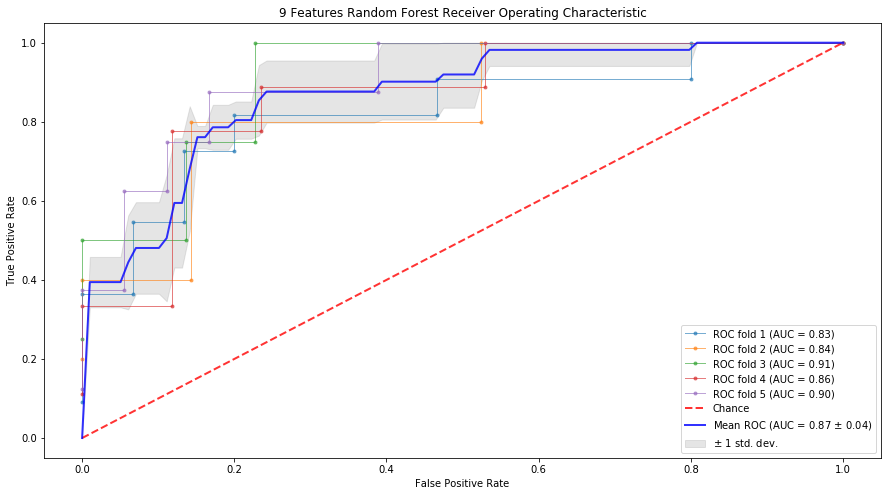

In [74]:
# Train RFC.

ppvs, npvs, sensitivitys, specificitys = [], [], [], []

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for i in np.arange(0, n_fold): 
    print("------------------------ Fold %d --------------------------" %(i+1)) 

    X_train, X_test = X[train_fold_mask[i]], X[val_fold_mask[i]]
    
    asm_train, asm_test = asm[train_fold_mask[i]], asm[val_fold_mask[i]] 
    asm_h2_train, asm_h2_test = asm_h2[train_fold_mask[i]], asm_h2[val_fold_mask[i]]
    sarcopenia_train, sarcopenia_test = sarcopenia[train_fold_mask[i]], sarcopenia[val_fold_mask[i]]
    gender_train, gender_test = gender[train_fold_mask[i]], gender[val_fold_mask[i]]
    height_squared_train, height_squared_test = height_squared[train_fold_mask[i]], height_squared[val_fold_mask[i]]
    patient_id_train, patient_id_test = patient_id[train_fold_mask[i]], patient_id[val_fold_mask[i]]
    
    clf_RFC = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
    clf_RFC.fit(X_train, sarcopenia_train)
    #print(clf_RFC.feature_importances_)

    # Observe Model.
    #observe_prediction_SVC(clf_RFC, X_train, sarcopenia_train, patient_id_train, dont_show=False, log=use_log, setname='Training')
    #result_train_RFC = clf_RFC.predict(X_train)
    #eval_classifier(result_train_RFC, sarcopenia_train, show_detail=True, log=use_log, setname='Training')

    #observe_prediction_SVC(clf_RFC, X_test, sarcopenia_test, patient_id_test, dont_show=False, log=use_log, setname='Validation')
    result_test_RFC = clf_RFC.predict(X_test)
    eval_classifier(result_test_RFC, sarcopenia_test, show_detail=True, log=use_log, setname='Validation')

    ppv, npv, sensitivity, specificity = eval_classifier_k_fold(result_test_RFC, sarcopenia_test)
    ppvs.append(ppv); npvs.append(npv); sensitivitys.append(sensitivity); specificitys.append(specificity);
    
    # Plot ROC Curve
    probs = clf_RFC.predict_proba(X_test)
    probs = probs[:, 1]
    fpr, tpr, thresholds = roc_curve(sarcopenia_test, probs)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.6, marker='.',
             label='ROC fold %d (AUC = %0.2f)' % (i+1, roc_auc))

print("------------------------ Overall Statistics --------------------------") 
print("ppv: %.3f +/- %.3f, \nnpv: %.3f +/- %.3f, \nsensitivity: %.3f +/- %.3f, \nspecificity: %.3f +/- %.3f\n" % 
      (np.mean(ppvs), np.std(ppvs, ddof=1), np.mean(npvs), np.std(npvs, ddof=1), np.mean(sensitivitys), np.std(sensitivitys, ddof=1), np.mean(specificitys), np.std(specificitys, ddof=1)))

# Plot ROC Curve

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)


mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs, ddof=1)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0, ddof=1)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%d Features Random Forest Receiver Operating Characteristic' % (len(include_feature_index)))
plt.legend(loc="lower right")
plt.show()



## Method II: Random Forest Regressor on asm/h2 (k-fold)

In [65]:
# Train RFR on asm/h2.

ppvs, npvs, sensitivitys, specificitys = [], [], [], []
for i in np.arange(0, n_fold): 
    print("------------------------ Fold %d --------------------------" %(i+1)) 

    X_train, X_test = X[train_fold_mask[i]], X[val_fold_mask[i]]
    
    asm_train, asm_test = asm[train_fold_mask[i]], asm[val_fold_mask[i]] 
    asm_h2_train, asm_h2_test = asm_h2[train_fold_mask[i]], asm_h2[val_fold_mask[i]]
    sarcopenia_train, sarcopenia_test = sarcopenia[train_fold_mask[i]], sarcopenia[val_fold_mask[i]]
    gender_train, gender_test = gender[train_fold_mask[i]], gender[val_fold_mask[i]]
    height_squared_train, height_squared_test = height_squared[train_fold_mask[i]], height_squared[val_fold_mask[i]]
    patient_id_train, patient_id_test = patient_id[train_fold_mask[i]], patient_id[val_fold_mask[i]]

    clf_RFR_asmh2 = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0)
    clf_RFR_asmh2.fit(X_train, asm_h2_train)
    #print(clf_RFR_asmh2.feature_importances_)

    # Training Set:
    #observe_prediction_asm_h2_SVR(clf_RFR_asmh2, X_train, asm_h2_train, gender_train, sarcopenia_train, patient_id_train, dont_show=False, log=use_log, setname='Training')
    #result_train_asm_h2_RFR = eval_sarcopenia_asm_h2(clf_RFR_asmh2, X_train, gender_train, sarcopenia_train)
    #eval_classifier(result_train_asm_h2_RFR, sarcopenia_train, show_detail=True, log=use_log, setname='Training')

    # Test Set:
    #observe_prediction_asm_h2_SVR(clf_RFR_asmh2, X_test, asm_h2_test, gender_test, sarcopenia_test, patient_id_test, dont_show=False, log=use_log, setname='Validation')
    result_test_asm_h2_RFR = eval_sarcopenia_asm_h2(clf_RFR_asmh2, X_test, gender_test, sarcopenia_test)
    eval_classifier(result_test_asm_h2_RFR, sarcopenia_test, show_detail=True, log=use_log, setname='Validation')

    ppv, npv, sensitivity, specificity = eval_classifier_k_fold(result_test_asm_h2_RFR, sarcopenia_test)
    ppvs.append(ppv); npvs.append(npv); sensitivitys.append(sensitivity); specificitys.append(specificity);
    

print("------------------------ Overall Statistics --------------------------") 
print("ppv: %.3f +/- %.3f, \nnpv: %.3f +/- %.3f, \nsensitivity: %.3f +/- %.3f, \nspecificity: %.3f +/- %.3f\n" % 
      (np.mean(ppvs), np.std(ppvs, ddof=1), np.mean(npvs), np.std(npvs, ddof=1), np.mean(sensitivitys), np.std(sensitivitys, ddof=1), np.mean(specificitys), np.std(specificitys, ddof=1)))



------------------------ Fold 1 --------------------------

Evaluating Validation set:
Positive: 7, Negative: 19
TP: 5, FP: 3, TN: 16, FN: 2
Correct: 21(26), Precision: 0.625, Recall: 0.714, Specificity: 0.842, F1-Score: 0.667

------------------------ Fold 2 --------------------------

Evaluating Validation set:
Positive: 8, Negative: 18
TP: 3, FP: 3, TN: 15, FN: 5
Correct: 18(26), Precision: 0.500, Recall: 0.375, Specificity: 0.833, F1-Score: 0.429

------------------------ Fold 3 --------------------------

Evaluating Validation set:
Positive: 7, Negative: 19
TP: 4, FP: 0, TN: 19, FN: 3
Correct: 23(26), Precision: 1.000, Recall: 0.571, Specificity: 1.000, F1-Score: 0.727

------------------------ Fold 4 --------------------------

Evaluating Validation set:
Positive: 9, Negative: 17
TP: 4, FP: 0, TN: 17, FN: 5
Correct: 21(26), Precision: 1.000, Recall: 0.444, Specificity: 1.000, F1-Score: 0.615

------------------------ Fold 5 --------------------------

Evaluating Validation set:
P

## Method III: Random Forest Regressor on asm (k-fold)

In [39]:
# Train RFR on asm.
ppvs, npvs, sensitivitys, specificitys = [], [], [], []
for i in np.arange(0, n_fold): 
    print("------------------------ Fold %d --------------------------" %(i+1)) 

    X_train, X_test = X[train_fold_mask[i]], X[val_fold_mask[i]]
    
    asm_train, asm_test = asm[train_fold_mask[i]], asm[val_fold_mask[i]] 
    asm_h2_train, asm_h2_test = asm_h2[train_fold_mask[i]], asm_h2[val_fold_mask[i]]
    sarcopenia_train, sarcopenia_test = sarcopenia[train_fold_mask[i]], sarcopenia[val_fold_mask[i]]
    gender_train, gender_test = gender[train_fold_mask[i]], gender[val_fold_mask[i]]
    height_squared_train, height_squared_test = height_squared[train_fold_mask[i]], height_squared[val_fold_mask[i]]
    patient_id_train, patient_id_test = patient_id[train_fold_mask[i]], patient_id[val_fold_mask[i]]
     
    clf_RFR = RandomForestRegressor(n_estimators=200, max_depth=None, random_state=0)
    clf_RFR.fit(X_train, asm_train)
    #print(clf_RFR.feature_importances_)

    # Training Set.
    #observe_prediction_asm_SVR(clf_RFR, X_train, asm_train, gender_train, height_squared_train, sarcopenia_train, patient_id_train, dont_show=False, log=use_log, setname='Training')
    #result_train_asm_RFR = eval_sarcopenia_asm(clf_RFR, X_train, gender_train, height_squared_train, sarcopenia_train)
    #eval_classifier(result_train_asm_RFR, sarcopenia_train, show_detail=True, log=use_log, setname='Training')

    # Test Set.
    #observe_prediction_asm_SVR(clf_RFR, X_test, asm_test, gender_test, height_squared_test, sarcopenia_test, patient_id_test, dont_show=False, log=use_log, setname='Validation')
    result_test_asm_RFR = eval_sarcopenia_asm(clf_RFR, X_test, gender_test, height_squared_test, sarcopenia_test)
    eval_classifier(result_test_asm_RFR, sarcopenia_test, show_detail=True, log=use_log, setname='Validation')
    
    ppv, npv, sensitivity, specificity = eval_classifier_k_fold(result_test_asm_RFR, sarcopenia_test)
    ppvs.append(ppv); npvs.append(npv); sensitivitys.append(sensitivity); specificitys.append(specificity);
    

print("------------------------ Overall Statistics --------------------------") 
print("ppv: %.3f +/- %.2f, \nnpv: %.3f +/- %.2f, \nsensitivity: %.3f +/- %.2f, \nspecificity: %.3f +/- %.2f\n" % 
      (np.mean(ppvs), np.std(ppvs, ddof=1), np.mean(npvs), np.std(npvs, ddof=1), np.mean(sensitivitys), np.std(sensitivitys, ddof=1), np.mean(specificitys), np.std(specificitys, ddof=1)))

    
    


Evaluating Validation set:
Positive: 3, Negative: 23
TP: 3, FP: 3, TN: 20, FN: 0
Correct: 23(26), Precision: 0.500, Recall: 1.000, Specificity: 0.870, F1-Score: 0.667


Evaluating Validation set:
Positive: 8, Negative: 18
TP: 1, FP: 1, TN: 17, FN: 7
Correct: 18(26), Precision: 0.500, Recall: 0.125, Specificity: 0.944, F1-Score: 0.200


Evaluating Validation set:
Positive: 5, Negative: 21
TP: 2, FP: 3, TN: 18, FN: 3
Correct: 20(26), Precision: 0.400, Recall: 0.400, Specificity: 0.857, F1-Score: 0.400


Evaluating Validation set:
Positive: 10, Negative: 16
TP: 5, FP: 4, TN: 12, FN: 5
Correct: 17(26), Precision: 0.556, Recall: 0.500, Specificity: 0.750, F1-Score: 0.526


Evaluating Validation set:
Positive: 11, Negative: 15
TP: 4, FP: 3, TN: 12, FN: 7
Correct: 16(26), Precision: 0.571, Recall: 0.364, Specificity: 0.800, F1-Score: 0.444

------------------------ Overall Statistics --------------------------
ppv: 0.505 +/- 0.07, 
npv: 0.781 +/- 0.15, 
sensitivity: 0.478 +/- 0.32, 
specific

## Measurement Index
$$Precision = \frac{True\ Positive}{True\ Positve + False\ Positive}$$
$$Recall = \frac{True\ Positive}{True\ Positive + False\ Negative}$$
$$F1\_Score = \frac{2 \times Precision \times Recall}{Precision + Recall}$$

$$PPV = \frac{True\ Positive}{True\ Positve + False\ Positive}$$
$$NPV = \frac{True\ Negative}{True\ Negative + False\ Negative}$$
$$Sensitivity = \frac{True\ Positive}{True\ Positive + False\ Negative}$$
$$Specificity = \frac{True\ Negative}{True\ Negative + False\ Positive}$$


|       |          | Actual   | Class  |
| :---  | ---      | ---      |    --- |
|       |          | Positive |Negative|
|Predict|Positive  | TP       | FP     |
| Class |Negative  | FN       | TN     |
